In [1]:
import numpy as np
import copy

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

color_list = [x["color"] for x in plt.rcParams["axes.prop_cycle"]]

from matplotlib.ticker import MaxNLocator

import multiprocessing
import os

In [2]:
from lut import *

## Toy example from paper

In [ ]:
X = np.array(
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 1, 0],
        [1, 1, 0],
    ],
    dtype=bool,
)

y = np.array([0, 1, 1, 1, 0, 0, 1], dtype=bool)

## Experiments

In [ ]:
data = np.load("MNIST.npz", allow_pickle=True)
X_ = data["X"]
y_ = data["y"]

scaler = MinMaxScaler(feature_range=(0, 1))
X_tf = scaler.fit_transform(X_)

In [ ]:
X = (X_tf > 0.5).astype(bool)
y = (y_ == 0) | (y_ == 1) | (y_ == 2) | (y_ == 3) | (y_ == 4)

X, y = shuffle(X, y, n_samples=10_000, random_state=100)

X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.33, random_state=42, shuffle=False
)

In [ ]:
%%time
lut = Lut(6, [100, 100, 100])
preds_train = lut.train(X_train, y_train)
preds_test = lut.predict(X_test)

print(f"Accuracy on training set: {accuracy_score(preds_train, y_train):.2f}%")
print(f"Accuracy on test set: {accuracy_score(preds_test, y_test):.2f}%")

In [ ]:
rnd_arr = []
for i in range(2, 11):
    lut = Lut(6, [100] * i)
    preds_train = lut.train(X_train, y_train)
    rnd_arr.append([x.sum() / len(x.ravel()) for x in lut.rnd_arr_])

In [ ]:
fig, ax = plt.subplots(1, 1)
for i, rnd in enumerate(rnd_arr):
    ax.plot(range(2, len(rnd) + 2), rnd, label=i + 2)
    
ax.grid()
ax.set_xticks(range(2, 13))
ax.set_xticklabels(range(2, 13))
ax.set_xlabel("Hidden layer")
ax.set_ylabel("Percentage of lut entries random")
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Number of\nhidden layers\nof respective\nlut network")
ax.set_title("Percentage of random entries for different architectures\nEach hidden layer has 100 luts");
# ax.xaxis.set_major_locator(MaxNLocator(integer=True));

## Grid of bits and architectures

In [ ]:
bit_arr = list(range(4, 13))
arc_arr = [[100] * i for i in range(4, 10)]

train_mesh = np.zeros((len(bit_arr), len(arc_arr)), dtype=np.float32)
test_mesh = np.zeros((len(bit_arr), len(arc_arr)), dtype=np.float32)
for i, bits in enumerate(tqdm(bit_arr)):
    for j, arc in enumerate(arc_arr):
        lut = Lut(bits, arc)
        preds_train = lut.train(X_train, y_train)
        preds_test = lut.predict(X_test)
        train_mesh[i, j] = accuracy_score(preds_train, y_bool_train)
        test_mesh[i, j] = accuracy_score(preds_test, y_bool_test)

In [3]:
tmp = np.load(r"data/lut/k_arc_run.npz")
train_mesh = tmp["train_mesh"]
test_mesh = tmp["test_mesh"]
bit_arr = list(range(4, 13))
arc_arr = [[100] * i for i in range(4, 10)]

In [4]:
# plt.rcParams.update(
#     {"text.usetex": True,}
# )

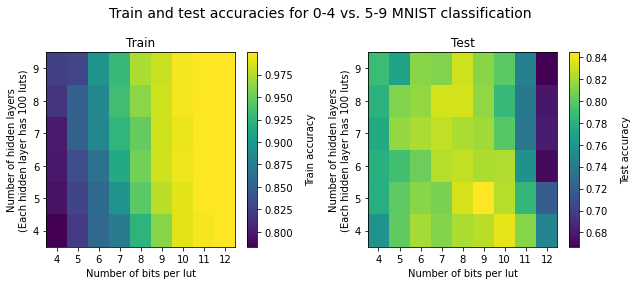

In [5]:
x = np.arange(len(bit_arr) + 1)
y = np.arange(len(arc_arr) + 1)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

ax = axs[0]
pm = ax.pcolormesh(x, y, train_mesh.T, shading="auto")
cbar = plt.colorbar(pm, ax=ax, label="Train accuracy")
cbar.ax.get_yaxis().labelpad = 13
ax.set_xlabel("Number of bits per lut")
ax.set_ylabel("Number of hidden layers\n(Each hidden layer has 100 luts)")
ax.set_xticks(x[:-1] + 0.5)
ax.set_xticklabels(bit_arr)
ax.set_yticks(y[:-1] + 0.5)
ax.set_yticklabels(list(range(4, 10)))
ax.set_title("Train")

ax = axs[1]
pm = ax.pcolormesh(x, y, test_mesh.T, shading="auto")
cbar = plt.colorbar(pm, ax=ax, label="Test accuracy")
cbar.ax.get_yaxis().labelpad = 13
ax.set_xlabel("Number of bits per lut")
ax.set_ylabel("Number of hidden layers\n(Each hidden layer has 100 luts)")
ax.set_xticks(x[:-1] + 0.5)
ax.set_xticklabels(bit_arr)
ax.set_yticks(y[:-1] + 0.5)
ax.set_yticklabels(list(range(4, 10)))
ax.set_title("Test")

fig.suptitle("Train and test accuracies for 0-4 vs. 5-9 MNIST classification", fontsize=14)

plt.tight_layout();

In [6]:
fig.savefig(f"seminar/images/layers_bits_acc.pdf", bbox_inches="tight")

In [12]:
from itertools import cycle

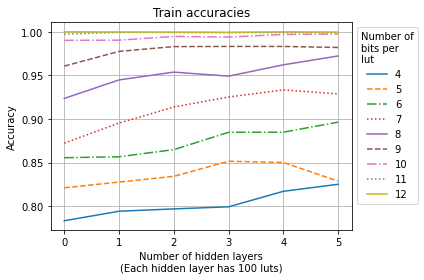

In [17]:
fig, ax = plt.subplots(1, 1)
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
for i, x in enumerate(train_mesh):
    ax.plot(x, label=bit_arr[i], ls=next(linecycler))
    
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Number of\nbits per\nlut")
ax.set_xlabel("Number of hidden layers\n(Each hidden layer has 100 luts)")
ax.set_ylabel("Accuracy")
ax.set_title("Train accuracies")
ax.grid()
plt.tight_layout();

In [18]:
fig.savefig(r"seminar/images/depth_improves_performance.pdf", bbox_inches="tight")